### Install necessary packages (Optional)

If the required packages are not yet installed in the environment, you can run the following command to install the necessary packages.

In [82]:
!pip install -r requirements.txt

### Import the following modules

The following modules will be used to complete the task of the project.

In [90]:
from selenium import webdriver
from selenium.webdriver.common.by import By
from selenium.webdriver.chrome.options import Options
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.ensemble import RandomForestRegressor
from xgboost import XGBRegressor
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import StandardScaler

Open the given URL

Note: A website will open after you execute the code below. You can ignore it and proceed with the next steps.

In [91]:
driver = webdriver.Chrome()
url = 'https://www.accuweather.com/en/ph/baguio-city/1-262309_1_al/daily-weather-forecast/1-262309_1_al'

driver.get(url)

### Data Scraping from AccuWeather

Using Selenium, we will scrape the data from the AccuWeather website. Before proceeding, we first inspect the website to check the necessary elements to be able to locate the data we need.

<img src = "img/url-elements.png" alt = "accuweather elements" width="50%" height="50%" />

By inspecting one of the cards in the website, we determine that the following class names are to be used to locate and complete the data that we need.

In [92]:
date_raw = driver.find_elements(By.CLASS_NAME, 'date') # extract the dates
temp_raw = driver.find_elements(By.CLASS_NAME, 'temp') # extract the temperature
precip_raw = driver.find_elements(By.CLASS_NAME, 'precip') # extract the precipitation probability 
condition_raw = driver.find_elements(By.CLASS_NAME, 'phrase') # extract the weather condition
realFeel_raw = driver.find_elements(By.CLASS_NAME, 'left') # extract the real feel temperature
uvIndAndWind_raw = driver.find_elements(By.CLASS_NAME, 'right') # extract the max UV index and wind

Next, we check the structure of the scraped data to determine the necessary steps to clean the data.

In [96]:
raw_data = []
for i in range(len(temp_raw)):
    raw_data.append({
        'date_raw': date_raw[i].text,
        'temp_raw': temp_raw[i].text,
        'precip_raw': precip_raw[i].text,
        'condition_raw': condition_raw[i].text,
        'realFeel_raw': realFeel_raw[i].text,
        'uvIndAndWind_raw': uvIndAndWind_raw[i].text
    })

df_raw = pd.DataFrame(raw_data)
df_raw.head(15)

,date_raw,temp_raw,precip_raw,condition_raw,realFeel_raw,uvIndAndWind_raw
0,THU\n7/25,21° /19°,55%,Overcast with a thunderstorm in parts of the area,,
1,THU,23° /20°,95%,A thick cloud cover with a couple of showers a...,RealFeel®\n18°\nCloud Cover\n100%,Wind\nSSW 7 km/h\nWind Gusts\n22 km/h
2,7/25,24° /19°,92%,Considerable cloudiness and humid with a coupl...,RealFeel®\n28°\nRealFeel Shade™\n24°,Max UV Index\n6 High\nWind\nSSW 9 km/h
3,FRI\n7/26,22° /19°,98%,"Thunderstorms, some can be heavy late; cloudy",RealFeel®\n29°\nRealFeel Shade™\n24°,Max UV Index\n6 High\nWind\nS 9 km/h
4,FRI,21° /19°,96%,Cloudy with showers and thunderstorms,RealFeel®\n26°\nRealFeel Shade™\n23°,Max UV Index\n4 Moderate\nWind\nWNW 6 km/h
5,7/26,21° /19°,74%,Cloudy with a couple of showers and a thunders...,RealFeel®\n26°\nRealFeel Shade™\n22°,Max UV Index\n5 Moderate\nWind\nW 7 km/h
6,SAT\n7/27,22° /18°,75%,Remaining cloudy with a couple of showers and ...,RealFeel®\n24°\nRealFeel Shade™\n22°,Max UV Index\n3 Moderate\nWind\nW 7 km/h
7,SAT,23° /18°,68%,Mostly cloudy with showers and thunderstorms,RealFeel®\n26°\nRealFeel Shade™\n21°,Max UV Index\n6 High\nWind\nWSW 7 km/h
8,7/27,23° /18°,60%,Mostly cloudy with a couple of showers and a t...,RealFeel®\n28°\nRealFeel Shade™\n24°,Max UV Index\n7 High\nWind\nW 9 km/h
9,SUN\n7/28,22° /18°,60%,Times of sun and clouds with a couple of showe...,RealFeel®\n25°\nRealFeel Shade™\n24°,Max UV Index\n7 High\nWind\nNW 4 km/h


From this raw structure, we can use the following takeaways to help us clean the data:
1. The `date_raw` element of a card results in three outputs: the combined date and day, the date, and the day.
2. The `temp_raw` contains both the high and low temperatures (in Celsius).
3. The `phrase_raw` contains the condition.
4. The `realFeel_raw` provided by `class='left'` contains the real feel temperature and real feel shade temperature (in Celsius).
5. The `uvIndAndWind_raw` provided by `class='right'` contains the max UV index and wind speed (in km/h).
6. Both the `realFeel_raw` and `uvIndAndWind_raw` are shifted by one index from the `date_raw`, `temp_raw`, and `phrase_raw`.

With this information, we now proceed to creating more structured data.

In [ ]:
data = []
for i in range(len(temp_raw)):
    [day, dateMMDD] = date_raw[3*i].text.split('\n')
    [tempHigh, tempLow] = temp_raw[i].text.split(' /')
    [_, realFeelTemp, _, realFeelShade] = realFeel_raw[i+1].text.split('\n')
    [_, maxUV, _, wind] = uvIndAndWind_raw[i+1].text.split('\n')
    [windDirection, windSpeed] = wind.split(' ', 1)
    data.append({
        'day': day,
        'date': dateMMDD,
        'tempHigh': tempHigh,
        'tempLow': tempLow,
        'condition': condition_raw[i].text,
        'precip': precip_raw[i].text,
        'realFeel': realFeelTemp,
        'realFeelShade': realFeelShade,
        'maxUV': maxUV,
        'windDirection': windDirection,
        'windSpeed': windSpeed
    })

df = pd.DataFrame(data)

driver.quit()


In [98]:
df.head(15)

,day,date,tempHigh,tempLow,condition,precip,realFeel,realFeelShade,maxUV,windDirection,windSpeed
0,THU,7/25,21°,19°,Overcast with a thunderstorm in parts of the area,55%,18°,100%,SSW 7 km/h,22,km/h
1,FRI,7/26,23°,20°,A thick cloud cover with a couple of showers a...,95%,28°,24°,6 High,SSW,9 km/h
2,SAT,7/27,24°,19°,Considerable cloudiness and humid with a coupl...,92%,29°,24°,6 High,S,9 km/h
3,SUN,7/28,22°,19°,"Thunderstorms, some can be heavy late; cloudy",98%,26°,23°,4 Moderate,WNW,6 km/h
4,MON,7/29,21°,19°,Cloudy with showers and thunderstorms,96%,26°,22°,5 Moderate,W,7 km/h
5,TUE,7/30,21°,19°,Cloudy with a couple of showers and a thunders...,74%,24°,22°,3 Moderate,W,7 km/h
6,WED,7/31,22°,18°,Remaining cloudy with a couple of showers and ...,75%,26°,21°,6 High,WSW,7 km/h
7,THU,8/1,23°,18°,Mostly cloudy with showers and thunderstorms,68%,28°,24°,7 High,W,9 km/h
8,FRI,8/2,23°,18°,Mostly cloudy with a couple of showers and a t...,60%,25°,24°,7 High,NW,4 km/h
9,SAT,8/3,22°,18°,Times of sun and clouds with a couple of showe...,60%,27°,23°,9 Very High,NNW,4 km/h


Notice that the `realFeelShade`, `maxUV`, `windDirection`, and `windSpeed` data of the first row have different values than the rest of the rows. This is because AccuWeather provides other relevant information about the weather today, such as highlighted in the image below, which is not available for the rest of the days.

<img src="img/other-information.png" alt="checking card differences" width="50%" height="50%" />

The modifications of relevant information happen in the current date. In my case, I wrote this notebook on July 25, 2024. To address this and prevent from happening again, we will omit the first row before saving the CSV file.

In [99]:
df = df.drop(0)

In [100]:
df.head(5)

,day,date,tempHigh,tempLow,condition,precip,realFeel,realFeelShade,maxUV,windDirection,windSpeed
1,FRI,7/26,23°,20°,A thick cloud cover with a couple of showers a...,95%,28°,24°,6 High,SSW,9 km/h
2,SAT,7/27,24°,19°,Considerable cloudiness and humid with a coupl...,92%,29°,24°,6 High,S,9 km/h
3,SUN,7/28,22°,19°,"Thunderstorms, some can be heavy late; cloudy",98%,26°,23°,4 Moderate,WNW,6 km/h
4,MON,7/29,21°,19°,Cloudy with showers and thunderstorms,96%,26°,22°,5 Moderate,W,7 km/h
5,TUE,7/30,21°,19°,Cloudy with a couple of showers and a thunders...,74%,24°,22°,3 Moderate,W,7 km/h


We now see a more structured data. Save the data to a CSV file.

In [101]:
# save the data to a csv file
df.to_csv('weather_data.csv', index=False)

### Data Cleaning

For the analysis, we would want to use all the numerical data as much as possible. Thus, we convert the different columns to their respective data types.

In [103]:
# load the data from the csv file
weather_data = pd.read_csv('weather_data.csv')

weather_data.head(5)

,day,date,tempHigh,tempLow,condition,precip,realFeel,realFeelShade,maxUV,windDirection,windSpeed
0,FRI,7/26,23°,20°,A thick cloud cover with a couple of showers a...,95%,28°,24°,6 High,SSW,9 km/h
1,SAT,7/27,24°,19°,Considerable cloudiness and humid with a coupl...,92%,29°,24°,6 High,S,9 km/h
2,SUN,7/28,22°,19°,"Thunderstorms, some can be heavy late; cloudy",98%,26°,23°,4 Moderate,WNW,6 km/h
3,MON,7/29,21°,19°,Cloudy with showers and thunderstorms,96%,26°,22°,5 Moderate,W,7 km/h
4,TUE,7/30,21°,19°,Cloudy with a couple of showers and a thunders...,74%,24°,22°,3 Moderate,W,7 km/h


Looking into the data again, we can see which columns provide numerical values. We can extract these values and convert them to integers since they do not contain any decimal points.

In [104]:
# convert the date column to date format; here I added the year 2024 to the date because it is not included in the raw data
weather_data['date'] = pd.to_datetime(weather_data['date'] + '/2024').dt.strftime('%m/%d/%Y')

# remove the '°' from the columns containing temperature values and convert them to integers
weather_data['tempHigh'] = weather_data['tempHigh'].str.replace('°', '').astype(int)
weather_data['tempLow'] = weather_data['tempLow'].str.replace('°', '').astype(int)
weather_data['realFeel'] = weather_data['realFeel'].str.replace('°', '').astype(int)
weather_data['realFeelShade'] = weather_data['realFeelShade'].str.replace('°', '').astype(int)

# remove the '%' from the precip column and convert it to integers
weather_data['precip'] = weather_data['precip'].str.replace('%', '').astype(int)

# remove the strings from the maxUV and windSpeed columns and convert the numbers to integer format
weather_data['maxUV'] = weather_data['maxUV'].str.split(' ').str[0].astype(int)
weather_data['windSpeed'] = weather_data['windSpeed'].str.split(' ').str[0].astype(int)

# since the day, condition, and windDirection columns do not contain numerical values, we will drop them
weather_data = weather_data.drop(columns=['day', 'condition', 'windDirection'])

Let us now check the cleaned data.

In [105]:
weather_data.head(5)

,date,tempHigh,tempLow,precip,realFeel,realFeelShade,maxUV,windSpeed
0,07/26/2024,23,20,95,28,24,6,9
1,07/27/2024,24,19,92,29,24,6,9
2,07/28/2024,22,19,98,26,23,4,6
3,07/29/2024,21,19,96,26,22,5,7
4,07/30/2024,21,19,74,24,22,3,7


Since we are able to extract the numerical values from the columns, we can now save the cleaned data and proceed to analysis.

In [106]:
weather_data.to_csv('weather_data_clean.csv', index=False)

Data Visualization

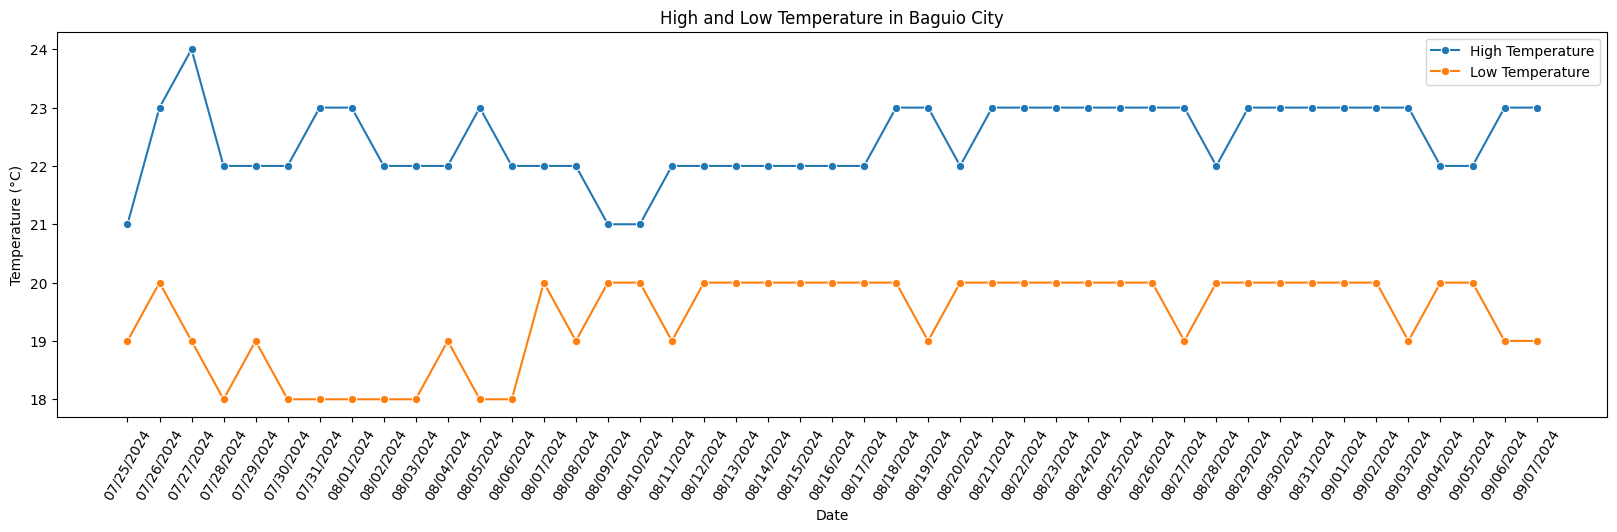

In [83]:
plt.figure(figsize=(20, 5))
sns.lineplot(x='date', y='tempHigh', data=weather_data, label='High Temperature', marker='o')
sns.lineplot(x='date', y='tempLow', data=weather_data, label='Low Temperature', marker='o')
plt.title('High and Low Temperature in Baguio City')
plt.xlabel('Date')
plt.ylabel('Temperature (°C)')
plt.xticks(rotation=60)
plt.legend()
plt.show()

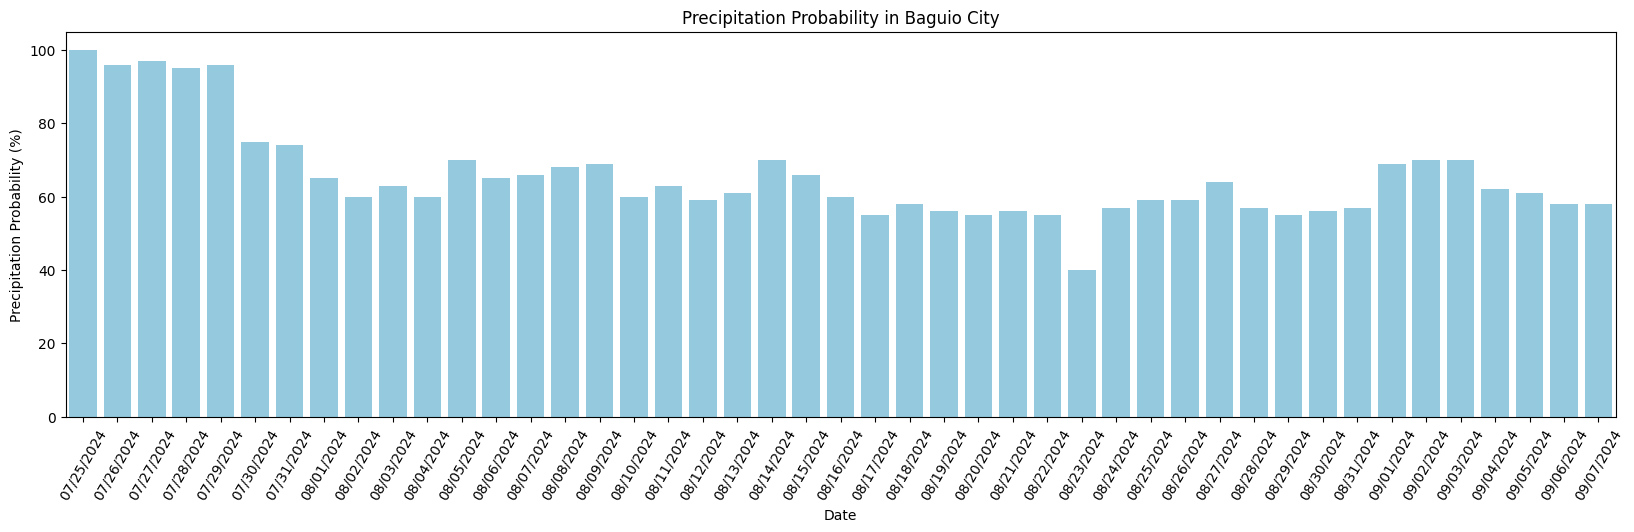

In [86]:
plt.figure(figsize=(20, 5))
sns.barplot(x='date', y='precip', data=weather_data, color='skyblue')
plt.title('Precipitation Probability in Baguio City')
plt.xlabel('Date')
plt.ylabel('Precipitation Probability (%)')
plt.xticks(rotation=60)

plt.show()


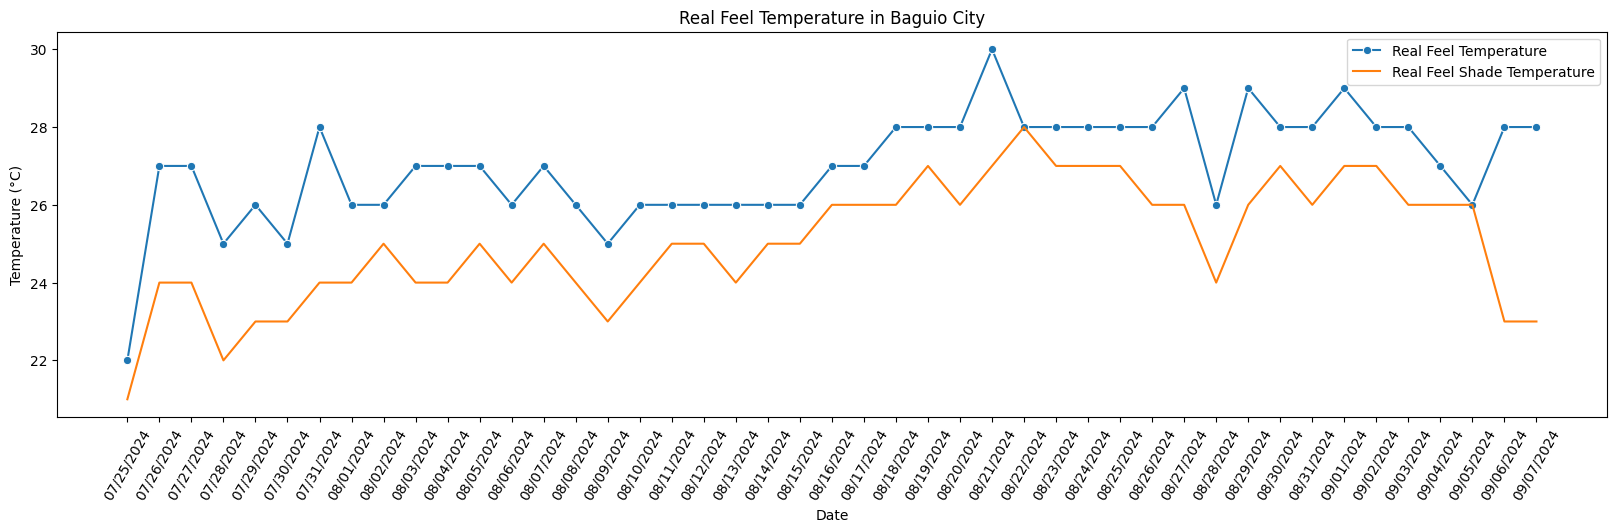

In [87]:
plt.figure(figsize=(20, 5))
sns.lineplot(x='date', y='realFeel', data=weather_data, label='Real Feel Temperature', marker='o')
sns.lineplot(x='date', y='realFeelShade', data=weather_data, label='Real Feel Shade Temperature')
plt.title('Real Feel Temperature in Baguio City')
plt.xlabel('Date')
plt.ylabel('Temperature (°C)')
plt.xticks(rotation=60)
plt.legend()

plt.show()

Data Correlation

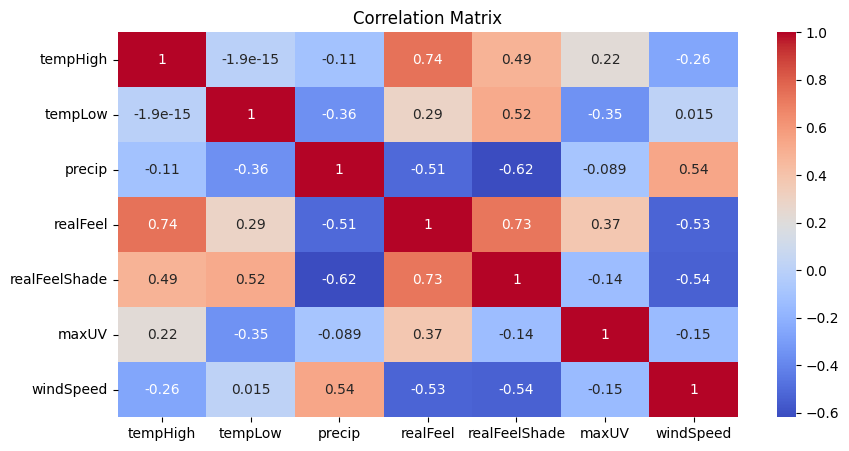

In [88]:
corr_matrix = weather_data[['tempHigh', 'tempLow', 'precip', 'realFeel', 'realFeelShade', 'maxUV', 'windSpeed']].corr()
plt.figure(figsize=(10, 5))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm')
plt.title('Correlation Matrix')
plt.show()

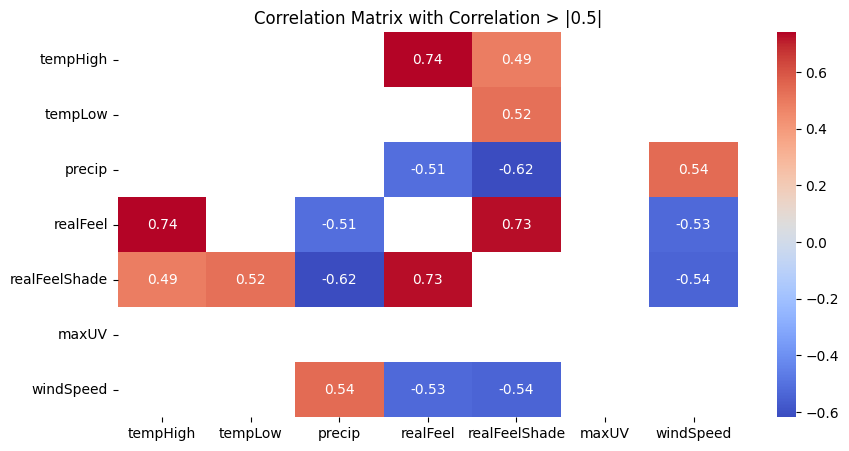

In [89]:
corr_matrix_high = corr_matrix[(corr_matrix.abs() > 0.4) & (corr_matrix.abs() < 1)]
corr_matrix_low = corr_matrix[corr_matrix < 0.5]

plt.figure(figsize=(10, 5))
sns.heatmap(corr_matrix_high, annot=True, cmap='coolwarm')
plt.title('Correlation Matrix with Correlation > |0.5|')
plt.show()

Feature Analysis

In [64]:
X = normalized_data.drop(columns=['tempHigh', 'realFeel'])
y = normalized_data['tempHigh']
model = RandomForestRegressor()
model.fit(X, y)
feature_importances = model.feature_importances_
features = X.columns

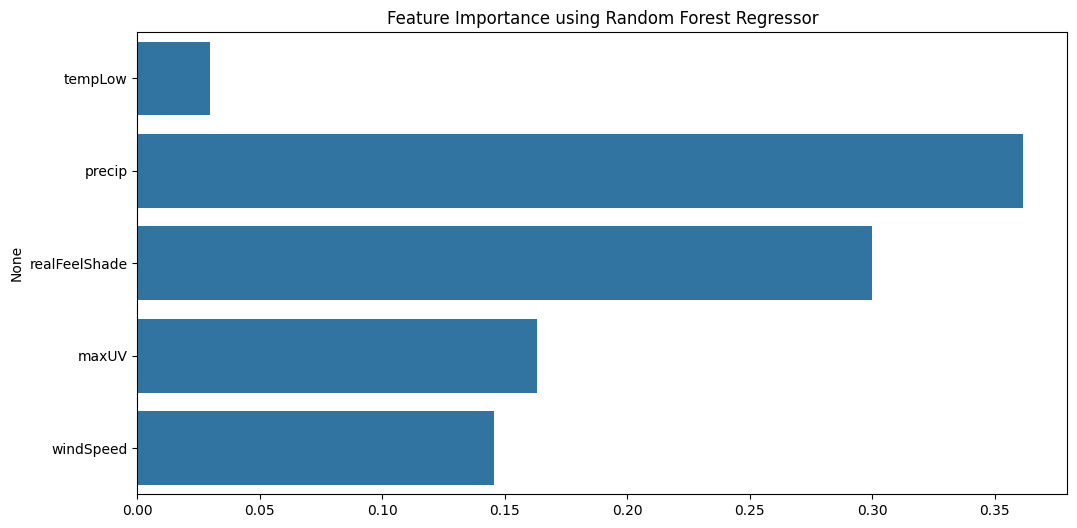

In [65]:
# Plot feature importances
plt.figure(figsize=(12, 6))
sns.barplot(x=feature_importances, y=features)
plt.title('Feature Importance using Random Forest Regressor')
plt.show()

In [52]:
modelXGB = XGBRegressor()
modelXGB.fit(X, y)
feature_importances_XGB = modelXGB.feature_importances_
features = X.columns

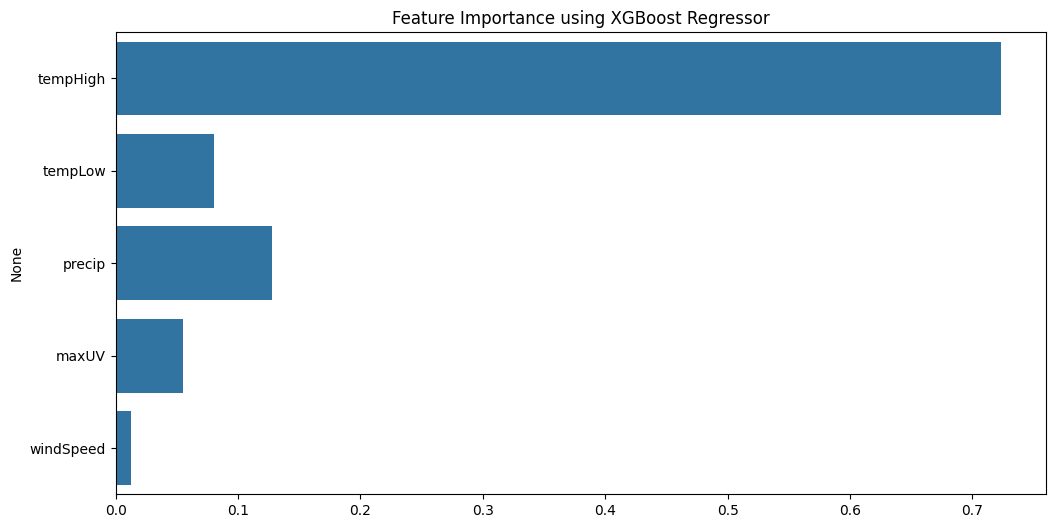

In [53]:
plt.figure(figsize=(12, 6))
sns.barplot(x=feature_importances_XGB, y=features)
plt.title('Feature Importance using XGBoost Regressor')
plt.show()

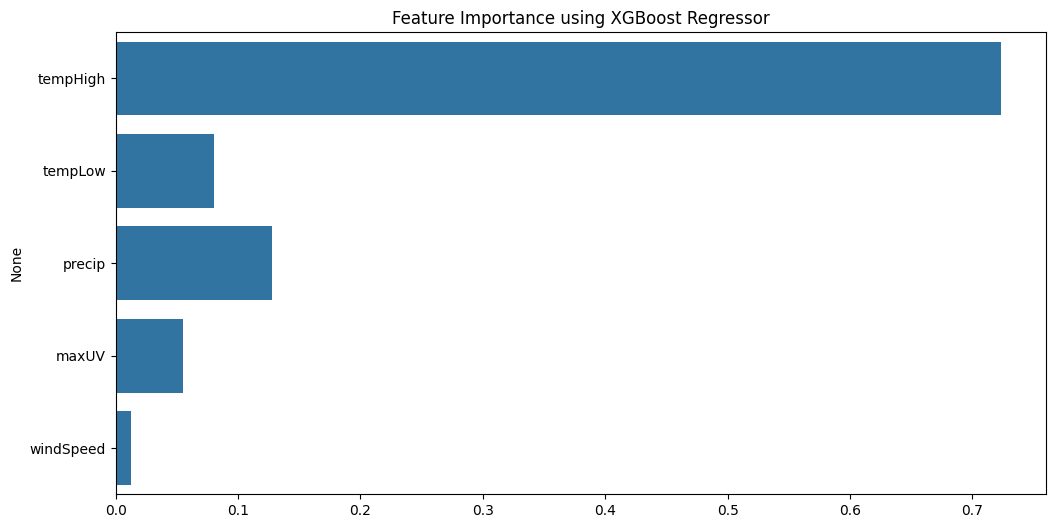

In [41]:
plt.figure(figsize=(12, 6))
sns.barplot(x=feature_importances_XGB, y=features)
plt.title('Feature Importance using XGBoost Regressor')
plt.show()